# Домашнее задание №3

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать **CV_HSE_2021 HW3 <Фамилия Имя>**

soft deadline: 21.03.2021T23:59:00+0300

hard deadline: 28.03.2021T23:59:00+0300


In [1]:
import cv2
import matplotlib.pylab as plt
import numpy as np
from ipywidgets import interact, widgets, fixed
from itertools import combinations, product, permutations
from tqdm.notebook import tqdm
import seaborn as sns
sns.set()
from joblib import Parallel, delayed
import os
from imgmorph import ImgMorph
from dataset import MyDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from itertools import combinations, product, permutations
import pandas as pd
from os import makedirs
from logger import Logger
import uuid


%matplotlib inline
plt.style.use('default')

## Legacy классификация

**Задане 1 (10 баллов)**

Реализуйте функцию, которая строит банк фильтров Габора.
Реализуйте интерактивный инструмент, в котором с помощью 2-х ползунков, один из которых отвечает за угол, другой за масштаб для фильтров из банка, можно выбрать конкретный фильтр и на экране отобразятся:
- Фильтр в пространственной области
- Фильтр в частотном пространстве
- Результат применения этого фильтра к какому-нибудь изображению.

In [2]:
def grid(array, ncols=3):  
    # https://stackoverflow.com/questions/42040747/more-idiomatic-way-to-display-images-in-a-grid-with-numpy
    nindex, height, width, intensity = array.shape
    nrows = nindex // ncols
    return (array.reshape(nrows, ncols, height, width, intensity).swapaxes(1,2).reshape(height*nrows, width*ncols, intensity))

def show(img, size=3):
    plt.figure(figsize=(size, size))
    ax = plt.axes([0, 0, 1, 1], frameon=False)
    ax.set_axis_off()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [3]:
def gabour_bank(size, phi_bins, scale_bins, max_scale, min_scale, sigma_scale=0.1, psi=0):
    """
    Parameters:
    size (tuple|int): Size or radius of filters.
    phi_bins (int): Number of angle beens of bank
    scale_bins (int): Number of scales betwwen max_scale and min_scale
    max_scale (float): Max frequency covered by bank
    min_scale (float): Min frequency covered by bank
    Returns:
    list: a list of filters
    """

    if isinstance(size, int):
        size_ = (size, size)
    else:
        size_ = size

    lambdas = np.linspace(min_scale, max_scale, scale_bins)
    thetas = np.linspace(0, np.pi, phi_bins, endpoint=False)
    filters = np.zeros((scale_bins, phi_bins, *size_))
    for i, lam in enumerate(lambdas):
        sigma = sigma_scale * lam
        for j, theta in enumerate(thetas):
            kernel = cv2.getGaborKernel(size_, sigma, theta, lam, gamma=1, psi=psi)
            kernel[kernel > 0] /= np.sum(kernel[kernel > 0])
            kernel[kernel < 0] /= np.abs(np.sum(kernel[kernel < 0]))
            filters[i, j] = np.copy(kernel)
    return filters

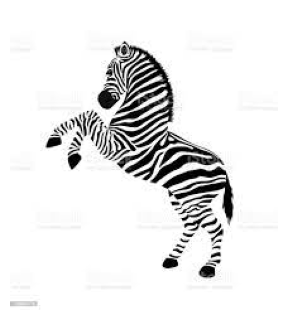

In [4]:
img = ImgMorph(cv2.imread('zebra.png')).gray()
img.picture

In [5]:
def gabor_filter(img, scale_idx, angle_idx, eps=1e-8, size=15):
    kernel = filters_bank[scale_idx, angle_idx]
    
    fft = np.fft.fft2(kernel)
    fft_shift = np.fft.fftshift(fft)
    ms = np.log(np.abs(fft_shift) + eps)
    
    filter_img = img.filter2D(kernel)

    fig, ax = plt.subplots(1, 3, figsize=(size, size * 3))

    ax[0].imshow(kernel, 'gray')
    ax[0].set_title("Kernel")
    ax[0].axis("off")

    ax[1].imshow(ms, 'gray')
    ax[1].set_title("Freq")
    ax[1].axis("off")

    ax[2].imshow(filter_img.img, 'gray')
    ax[2].set_title("Filtered")
    ax[2].axis("off")


In [6]:
size = 51
angle_bins = 180
scale_bins = 30
max_scale = 51
min_scale = 3

filters_bank = gabour_bank(size, angle_bins, scale_bins, max_scale, min_scale, sigma_scale=0.25, psi=0)
interact(gabor_filter, scale_idx=widgets.IntSlider(min=0, max=scale_bins - 1, step=1, value=15), angle_idx=widgets.IntSlider(min=0, max=angle_bins - 1, step=1, value=0), size=fixed(15), img=fixed(img), eps=fixed(1e-8))

interactive(children=(IntSlider(value=15, description='scale_idx', max=29), IntSlider(value=0, description='an…

<function __main__.gabor_filter(img, scale_idx, angle_idx, eps=1e-08, size=15)>

**Задание 2 (15 баллов)** 

Постройте мешок визульных слов на основе SIFT дескртипторов для датасета из третьего задания. Для этого для каждой картинки примените функцию, которая извлекает sift keypoints с дексрипторами, для каждой картинки ограничьтесь, например, сотней. Проведите кластеризацию на N(~30) классов, для каждого кластра отбразите в ряду 5 ближайших к нему участков изображений, в соответствии с масштабом keypoint-а. отобразите N таких строк.

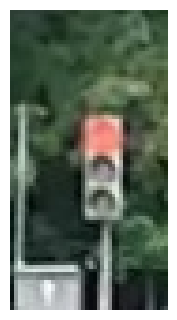

In [7]:
train = MyDataset("train_val/pic")
train[0].picture

In [8]:
%%time

sift = cv2.SIFT_create(100)

keypoints = []
descriptors = []
image_idxs = []

for idx, img in enumerate(train):
    if idx >= 1000:
        break
    
    k_, d_ = sift.detectAndCompute(img.img, None)

    if len(k_) > 0:
        for k, d in zip(k_, d_):
            keypoints.append(k)
            descriptors.append(d)
            image_idxs.append(idx)

image_idxs, keypoints, descriptors = map(lambda x: np.array(x), [image_idxs, keypoints, descriptors])

CPU times: user 7.68 s, sys: 1.25 s, total: 8.93 s
Wall time: 2.22 s


In [9]:
%%time

to_cut = []
to_plot = []
img_to_plot = []

kmeans = KMeans(n_clusters=30).fit(descriptors)
pred = kmeans.predict(descriptors)

for c in np.unique(kmeans.labels_):
    msk = pred == c
    kps = keypoints[msk]
    kp_d = [-kp.size for kp in kps]
    p = np.argpartition(kp_d, 5)[:5]
    for idx in p:
        kp = kps[idx]

        center = tuple(map(lambda x: np.ceil(x).astype(int), kp.pt))
        angle = kp.angle
        r = np.ceil(kp.size / 2).astype(int)

        rot = cv2.getRotationMatrix2D(center, angle, 1.0)
        sqr = train[image_idxs[msk][idx]].img

        img_to_plot.append(cv2.drawKeypoints(sqr, [kp], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

        sqr = cv2.warpAffine(sqr, rot, sqr.shape[:2][::-1], flags=cv2.INTER_LINEAR)
        to_plot.append(ImgMorph(sqr).crop(center[0], center[1], r, r))

TypeError: Can't parse 'center'. Sequence item with index 0 has a wrong type

In [10]:
%%time

n = len(to_plot)

cols = 5
rows = n // 5 * 2
size_ = 2

fig, ax = plt.subplots(rows, cols, figsize=(size_ * cols, size_ * rows))

idx = 0
for i in range(0, len(ax), 2):
    for j in range(len(ax[i])):
        ax[i][j].imshow(cv2.cvtColor(img_to_plot[idx], cv2.COLOR_BGR2RGB))
        ax[i][j].axis("off")

        ax[i + 1][j].imshow(cv2.cvtColor(to_plot[idx].img, cv2.COLOR_BGR2RGB))
        ax[i + 1][j].axis("off")
        
        idx += 1
plt.show()

ValueError: figure size must be positive finite not (10, 0)

**Задание 3 (20 баллов)**

[КОНКУРС](https://youtu.be/8GGWedu77SA?t=3388)

В этом задании вам придется проявить изобретательность. Используйте банки фильтов, мешки визуальных слов и гистрограммы для достижения максимального скора. [Настоящая ссылка на конкурс](https://www.kaggle.com/t/65dc3b38e1194d488ab276752fd1e92d). В этом задании баллы будут распределяться согласно тому, как далеко вы продвинулись на лидерборде. **Важное условие**, весь ваш код положите в этот ноутбук, в нем не должно быть нейросетей =) Только legacy только *hard core*

In [11]:
db = pd.read_csv("train_val/keys.csv")
img_names = db.id
y = db.category

In [12]:
def get_features(name, spaces=["bgr", "hsv", "lab"], bins=256, normalize=True):
    f = []
    img = ImgMorph(cv2.imread(name))
    
    if "bgr" in spaces:
        for h, _ in img.calculate_histogram(num_bins=bins, normalize=normalize):
            f.extend(h)

    if "hsv" in spaces:
        for h, _ in img.change_color_space(cv2.COLOR_BGR2HSV).calculate_histogram(num_bins=bins, normalize=normalize):
            f.extend(h)

    if "lab" in spaces:
        for h, _ in img.change_color_space(cv2.COLOR_BGR2LAB).calculate_histogram(num_bins=bins, normalize=normalize):
            f.extend(h)

    return f

In [13]:
def run(bins=50, normalize=False, n_estimators=500, n_jobs=6, min_samples_split=6, max_leaf_nodes=35, test_size=0.3, random_state=42, spaces=["bgr", "hsv", "lab"]):
    logger = Logger(locals())

    makedirs("experiments", exist_ok=True)
    log_dir = "experiments/" + str(uuid.uuid4()) + "/"
    makedirs(log_dir)
    logger.save_params(log_dir + "params.json")

    pred_names = [f"pic{num:06d}" for num in range(10699)]
    X_pred = []
    for name in pred_names:
        X_pred.append(get_features(f"test/pic/{name}.jpg", spaces=spaces, bins=bins, normalize=normalize))



    y = db.category
    X = []
    for idx, name in enumerate(img_names):
        X.append(get_features(f"train_val/pic/{name}.jpg", spaces, bins, normalize))

    X = np.array(X)[:, :, 0]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                n_jobs=n_jobs, 
                                min_samples_split=min_samples_split, 
                                max_leaf_nodes=max_leaf_nodes)
    rf.fit(X_train, y_train)
    y_test_pred = rf.predict(X_test)
    y_train_pred = rf.predict(X_train)
    score_train = accuracy_score(y_train, y_train_pred)
    score_val = accuracy_score(y_test, y_test_pred)

    logger.log("train", score_train)
    logger.log("val", score_val)
    logger.save(log_dir + "log.csv")
    return score_train, score_val, logger, rf

In [14]:
base_config = {
    "bins": 50, 
    "normalize": False, 
    "n_estimators": 500, 
    "min_samples_split": 6, 
    "max_leaf_nodes": 35,
    "test_size": 0.3,
    "spaces": ["bgr", "hsv", "lab"]
}

In [15]:
configs = []

params = product(
    (50, 100, 200),
    (True, False),
    (500, 1000, 1500),
    (6, ),
    (35, 50),
    (0.5, ),
    (["bgr", "hsv", "lab"], ["bgr", "hsv"], ["hsv", "lab"], ["bgr", "lab"], ["bgr"], ["hsv"], ["lab"])
)

for bins, normalize, n_estimators, min_samples_split, max_leaf_nodes, test_size, spaces in params:
    cfg = {
        "bins": bins, 
        "normalize": normalize, 
        "n_estimators": n_estimators, 
        "min_samples_split": min_samples_split, 
        "max_leaf_nodes": max_leaf_nodes,
        "test_size": test_size,
        "spaces": spaces
    }
    configs.append(cfg)

In [ ]:
best_log = None
best_rf = None
best_score = 0

t = tqdm(configs)
for cfg in t:
    score_train, score_val, logger, rf = run(**cfg, n_jobs=4)
    t.set_description(f"train = {score_train:0.4f} | val = {score_val:0.4f}")

    if score_val > best_score:
        best_score = score_val
        best_log = logger
        best_rf = rf
        print(best_log.params, best_score)

  0%|          | 0/252 [00:00<?, ?it/s]

{'bins': 50, 'normalize': True, 'n_estimators': 500, 'n_jobs': 4, 'min_samples_split': 6, 'max_leaf_nodes': 35, 'test_size': 0.5, 'random_state': 42, 'spaces': ['bgr', 'hsv', 'lab']} 0.8387167462856642
{'bins': 50, 'normalize': True, 'n_estimators': 500, 'n_jobs': 4, 'min_samples_split': 6, 'max_leaf_nodes': 35, 'test_size': 0.5, 'random_state': 42, 'spaces': ['hsv', 'lab']} 0.8410834027260377
{'bins': 50, 'normalize': True, 'n_estimators': 500, 'n_jobs': 4, 'min_samples_split': 6, 'max_leaf_nodes': 35, 'test_size': 0.5, 'random_state': 42, 'spaces': ['bgr', 'lab']} 0.8412587106105097
{'bins': 50, 'normalize': True, 'n_estimators': 500, 'n_jobs': 4, 'min_samples_split': 6, 'max_leaf_nodes': 35, 'test_size': 0.5, 'random_state': 42, 'spaces': ['lab']} 0.8425296927729324
{'bins': 50, 'normalize': True, 'n_estimators': 500, 'n_jobs': 4, 'min_samples_split': 6, 'max_leaf_nodes': 50, 'test_size': 0.5, 'random_state': 42, 'spaces': ['bgr', 'hsv', 'lab']} 0.8457728886356664
{'bins': 50, 'norm

In [ ]:
def pred(train_img, y, pred_names, bins=50, normalize=True, n_estimators=500, n_jobs=6, min_samples_split=6, max_leaf_nodes=35, test_size=0.3, random_state=42, spaces=["bgr", "hsv", "lab"]):

    X_train = []
    for idx, name in enumerate(train_img):
        X_train.append(get_features(name, spaces, bins, normalize))
    X_train = np.array(X_train)[:, :, 0]

    X_pred = []
    for idx, name in enumerate(pred_names):
        X_pred.append(get_features(name, spaces, bins, normalize))
    X_pred = np.array(X_pred)[:, :, 0]

    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                n_jobs=n_jobs, 
                                min_samples_split=min_samples_split, 
                                max_leaf_nodes=max_leaf_nodes)
    rf.fit(X_train, y)
    y_pred = rf.predict(X_pred)

    pd.DataFrame({
    "id": pred_names,
    "category": y_pred
    }).to_csv("out.csv", index=False)


In [ ]:
cfg = {'bins': 100, 'normalize': True, 'n_estimators': 1500, 'n_jobs': 4, 'min_samples_split': 6, 'max_leaf_nodes': 50, 'test_size': 0.3, 'random_state': 42, 'spaces': ['lab']}

In [ ]:
pred_img_names = [f"pic{num:06d}" for num in range(10699)]

db = pd.read_csv("train_val/keys.csv")
train_img_names = db.id
y = db.category

pred(train_img_names, y, pred_img_names, **cfg)